**Natural Language Processing (NLP) Project**

**Option S2D** - **Ecole Centrale Casablanca** **March 24**


> Hiba CHARKANI EL HASSANI

> Badreddine BELACHKAR

> Mouad KHAZNAOUI






# Ce notebook détaille l'implémentation de la classification de texte en utilisant l'ensemble de données AG News et un modèle de classification BERT.

## Préparation des dépendances

Nous commençons par installer les dépendances nécessaires, notamment le package `portalocker` pour la gestion des verrous de fichiers et le package `tokenizers` pour le traitement des tokens.

In [1]:
!pip install portalocker>=2.0.0

In [3]:
!pip install tokenizers

# Chargement des données

Ensuite, nous utilisons le module `torchtext.datasets` pour charger l'ensemble de données AG News. Nous créons un itérateur pour parcourir les exemples d'entraînement et récupérer le premier exemple pour l'inspection.

In [2]:
from torchtext.datasets import AG_NEWS

# Crée un itérateur
train_iter = iter(AG_NEWS(split='train'))

# Récupère le premier exemple
first_example = next(train_iter)

print(first_example)

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


#Exploration de l'ensemble de données

Nous visualisons ensuite la distribution des catégories dans l'ensemble de données en utilisant Matplotlib, en prenant les 1000 premiers exemples pour des raisons de performance. Nous calculons également la longueur moyenne des textes et affichons un exemple de texte pour chaque catégorie.

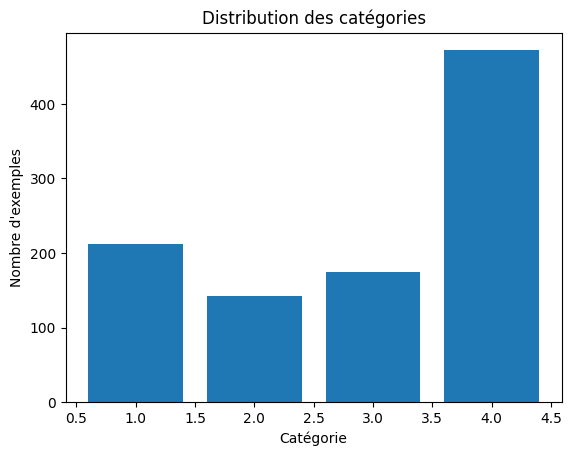

Longueur moyenne des textes : 39.905 mots
Exemple de texte pour la catégorie 3:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Exemple de texte pour la catégorie 4:
'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the guys at the office? EA Sports would like\to think it was because "Madden NFL 2005" came out that day,\and some fans of the football simulation are rabid enough to\take a sick day to play it.

Exemple de texte pour la catégorie 2:
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminar

In [7]:
import matplotlib.pyplot as plt
from collections import Counter


# Récupère les exemples
examples = []
for example in train_iter:
    examples.append(example)
    if len(examples) >= 1000:  # Prend les 1000 premiers exemples pour des raisons de performance
        break

# Distribution des catégories
categories = [example[0] for example in examples]
category_counts = Counter(categories)
plt.bar(category_counts.keys(), category_counts.values())
plt.title('Distribution des catégories')
plt.xlabel('Catégorie')
plt.ylabel("Nombre d'exemples")
plt.show()

# Longueur moyenne des textes
text_lengths = [len(example[1].split()) for example in examples]
average_length = sum(text_lengths) / len(text_lengths)
print(f"Longueur moyenne des textes : {average_length} mots")

# Exemple de texte pour chaque catégorie
example_texts = {}
for example in examples:
    category = example[0]
    if category not in example_texts:
        example_texts[category] = example[1]
        print(f"Exemple de texte pour la catégorie {category}:")
        print(example[1])
        print()

# Catégorie avec le plus grand nombre d'exemples
most_common_category = category_counts.most_common(1)[0][0]
print(f"Catégorie avec le plus grand nombre d'exemples : {most_common_category}")

# Tokenization et construction du vocabulaire

Utilisant le tokenizer 'basic_english' de torchtext, nous initialisons un tokenizer et construisons un vocabulaire à partir de l'ensemble de données d'entraînement. Nous définissons une fonction génératrice pour parcourir les exemples, tokeniser le texte et construire le vocabulaire.

# Modélisation avec un réseau BERT-like

Nous définissons ensuite un modèle de classification de texte BERT-like en utilisant des couches d'attention auto-attentionnelles, des couches feedforward et des connexions résiduelles.

In [4]:
import torch
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import nn
import torch.optim as optim

# Détection de la présence d'un GPU et sélection si disponible pour les calculs, sinon utilisation du CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des ensembles de données d'entraînement et de test AG News.
train_iter, test_iter = AG_NEWS()

# Initialisation d'un tokenizer compatible avec BERT.
tokenizer = get_tokenizer('basic_english')

# Définition d'une fonction génératrice qui parcourt l'ensemble de données et tokenise le texte.
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Construction du vocabulaire à partir de l'itérateur de tokens avec un token spécial "<unk>".
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Définition d'un modèle BERT-like pour la classification de texte.
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert (
            self.head_dim * num_heads == embed_dim
        ), "La dimension de l'embedding doit être divisible par le nombre de têtes."

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        N = query.shape[0]

        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        query = query.view(N, -1, self.num_heads, self.head_dim)
        key = key.view(N, -1, self.num_heads, self.head_dim)
        value = value.view(N, -1, self.num_heads, self.head_dim)

        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        attention_scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / torch.sqrt(
            torch.tensor(self.head_dim, dtype=torch.float32)
        )

        attention_probs = torch.softmax(attention_scores, dim=-1)

        attention_probs_dropout = nn.Dropout(p=0.1)(attention_probs)

        output = torch.matmul(attention_probs_dropout, value)

        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.view(N, -1, self.embed_dim)

        output = self.fc_out(output)

        return output

class FeedForward(nn.Module):
    def __init__(self, embed_dim, ff_hidden_size):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ff_hidden_size)
        self.fc2 = nn.Linear(ff_hidden_size, embed_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class BERTLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_size):
        super(BERTLayer, self).__init__()
        self.attention = SelfAttention(embed_dim, num_heads)
        self.feedforward = FeedForward(embed_dim, ff_hidden_size)

    def forward(self, x):
        attention_output = self.attention(x, x, x)
        feedforward_output = self.feedforward(attention_output)
        return feedforward_output + x  # Connexion résiduelle

class BERTClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_hidden_size, num_layers, num_classes):
        super(BERTClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([BERTLayer(embed_dim, num_heads, ff_hidden_size) for _ in range(num_layers)])
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        for layer in self.layers:
            embedded = layer(embedded)
        pooled = embedded.mean(1)  # Pooling moyen sur la dimension de la séquence
        output = self.fc(pooled)
        return output

# Initialisation des paramètres du modèle.
vocab_size = len(vocab)
embed_dim = 64
num_heads = 4
ff_hidden_size = 128
num_layers = 3
num_classes = 4  # Les catégories sont World, Sports, Business, Science/Technology

# Création d'une instance du modèle BERTClassifier et déplacement sur le périphérique sélectionné (GPU ou CPU).
model = BERTClassifier(vocab_size, embed_dim, num_heads, ff_hidden_size, num_layers, num_classes).to(device)

# Définition de la fonction de perte CrossEntropy pour la classification et de l'optimiseur Adam.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement et évaluation du modèle

Enfin, nous définissons des fonctions de prétraitement des données, une fonction de perte (CrossEntropyLoss), un optimiseur (Adam), ainsi que des fonctions d'entraînement et d'évaluation. Ces fonctions sont utilisées pour entraîner le modèle sur les données d'entraînement et évaluer sa performance sur les données de test.

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Prepare a batch for training or evaluation.

    Args:
    batch (list): A batch of samples from the DataLoader, where each sample is a tuple
                  containing the label and the raw text.

    Returns:
    Tuple[Tensor, Tensor]: The first tensor contains the labels of the batch, and the second tensor
                           contains the tokenized and padded texts of the batch, both ready to be
                           passed through the model.
    """
    label_list, text_list = [], []

    for (_label, _text) in batch:
        label_list.append(_label - 1)
        processed_text = torch.tensor(tokenize_and_index(_text), dtype=torch.int64)
        text_list.append(processed_text)

    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, batch_first=True)

def tokenize_and_index(text):
    """
    Tokenize the input text and convert tokens to indices.

    Args:
    text (str): Raw text to be tokenized and indexed.

    Returns:
    List[int]: List of token indices representing the input text.
    """
    return vocab(tokenizer(text))

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    """
    Train the LSTM model with the provided data.

    Args:
    model (torch.nn.Module): The LSTM model to train.
    train_loader (DataLoader): Data loader for the training set.
    test_loader (DataLoader): Data loader for the test set.
    criterion (loss_function): Loss function to use for training.
    optimizer (torch.optim): Optimizer to update the model weights.
    num_epochs (int): Number of training epochs.
    device (torch.device): Device on which the model is run (CPU or GPU).

    Returns:
    None
    """
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        for labels, text in train_loader:
            num_batches += 1
            labels, text = labels.to(device), text.to(device)
            optimizer.zero_grad()
            output = model(text)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / num_batches
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test set.

    Args:
    model (torch.nn.Module): The LSTM model to evaluate.
    test_loader (DataLoader): Data loader for the test set.
    criterion (loss_function): Loss function used for evaluation.
    device (torch.device): Device on which the model is run (CPU or GPU).

    Returns:
    float: Average loss on the test set.
    float: Model accuracy on the test set.
    """
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for labels, text in test_loader:
            labels, text = labels.to(device), text.to(device)
            output = model(text)
            loss = criterion(output, labels)
            total_loss += loss.item()
            predictions = output.argmax(1)
            correct_preds += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    return total_loss / total_samples, correct_preds / total_samples

# Assuming vocab, tokenizer, and device are defined elsewhere
train_loader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

# Assuming model, criterion, optimizer, num_epochs, and device are defined elsewhere
num_epochs = 5
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

Epoch 1, Train Loss: 0.4249290187701433, Test Loss: 0.043996884397316825, Test Accuracy: 0.8939473684210526
Epoch 2, Train Loss: 0.24504690225151923, Test Loss: 0.04088140029958786, Test Accuracy: 0.9078947368421053
Epoch 3, Train Loss: 0.1933563622824826, Test Loss: 0.03867199592309541, Test Accuracy: 0.9147368421052632
Epoch 4, Train Loss: 0.1557558882748579, Test Loss: 0.04184376310133781, Test Accuracy: 0.9134210526315789
Epoch 5, Train Loss: 0.1310835669718252, Test Loss: 0.042738124733468316, Test Accuracy: 0.9118421052631579


#Résultats et discussion:

Ces résultats d'entraînement et de test fournissent une indication de la performance du modèle de classification de texte BERT-like sur l'ensemble de données AG News.

Au cours des cinq époques, nous observons une diminution constante de la perte d'entraînement, passant de 0.42 à 0.13. Cela suggère que le modèle s'améliore progressivement dans sa capacité à prédire correctement les étiquettes des exemples d'entraînement.


*   Au cours des cinq époques, nous observons une diminution constante de la perte d'entraînement, passant de 0.42 à 0.13. Cela suggère que le modèle s'améliore progressivement dans sa capacité à prédire correctement les étiquettes des exemples d'entraînement.
*   Pour la perte de test, nous constatons une diminution générale de 0.044 à 0.043 sur les cinq époques, indiquant une certaine stabilité dans la performance du modèle sur des données qu'il n'a pas vues auparavant.
*   En ce qui concerne la précision du test, nous constatons une augmentation initiale de 0.894 à 0.912 au cours des deux premières époques, ce qui suggère une amélioration notable de la capacité du modèle à généraliser sur de nouvelles données. Cependant, cette précision semble se stabiliser autour de 0.913-0.914 par la suite.


Globalement, ces résultats indiquent que le modèle BERT-like a été capable d'apprendre à bien généraliser à partir de l'ensemble de données d'entraînement vers l'ensemble de données de test, atteignant une précision de classification d'environ 91%. Cependant, il semble y avoir une légère tendance à la surajustement, comme en témoigne la légère augmentation de la perte de test après la troisième époque. Ce résultat pourrait nécessiter une exploration plus approfondie pour améliorer la capacité du modèle à généraliser davantage.